In [ ]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import cv2

from sklearn.model_selection import train_test_split

import tensorflow as tf
import torch
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import EfficientNetB0

from tensorflow.keras.applications import DenseNet121

# from tensorflow.keras.applications import ResNet50, preprocess_input

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score

2024-08-17 19:27:06.755723: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-17 19:27:06.755856: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-17 19:27:06.903980: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
#!pip install vit-keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 1.5 MB/s eta 0:00:00


In [ ]:
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        print("Found a GPU with the name:", gpu)
else:
    print("Failed to detect a GPU.")

Found a GPU with the name: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [ ]:
positive_folder = '/kaggle/input/osteopenia/Osteoporosis Positive Images-20240816T104835Z-001/Osteoporosis Positive Images'
negative_folder = '/kaggle/input/negative-images/Osteoporosis Negative Images'

In [ ]:
dfn = pd.read_csv('/kaggle/input/osteopenia/df_osteopenia_nve (2).csv')
dfp = pd.read_csv('/kaggle/input/osteopenia/df_osteopenia_pve.csv')

In [ ]:
dfn_copy = dfn.copy()
dfp_copy = dfp.copy()
dfn_copy['filestem'] = dfn_copy['filestem'].astype(str) + '.png'
dfp_copy['filestem'] = dfp_copy['filestem'].astype(str) + '.png'
dfn_copy['osteopenia'] = 0

[ WARN:0@6.746] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/osteopenia/Osteoporosis Positive Images-20240816T104835Z-001/Osteoporosis Positive Images/0003_0664918633_03_WRI-R1_M011'): can't open/read file: check file path/integrity
[ WARN:0@6.746] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/osteopenia/Osteoporosis Positive Images-20240816T104835Z-001/Osteoporosis Positive Images/0028_0578333865_02_WRI-R1_M008'): can't open/read file: check file path/integrity
[ WARN:0@6.746] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/osteopenia/Osteoporosis Positive Images-20240816T104835Z-001/Osteoporosis Positive Images/0028_0579537263_03_WRI-R1_M008'): can't open/read file: check file path/integrity
[ WARN:0@6.746] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/osteopenia/Osteoporosis Positive Images-20240816T104835Z-001/Osteoporosis Positive Images/0033_1100149160_02_WRI-L1_F006'): can't open/read file: check file path/integrity
[ WARN:0@6.7

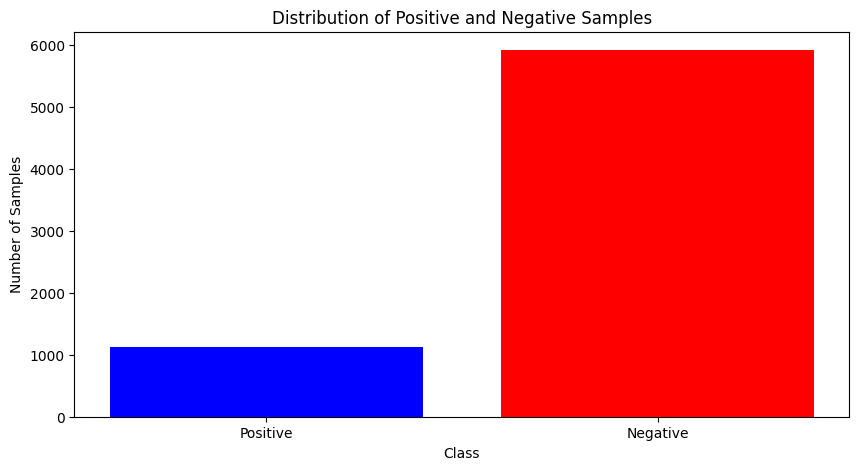

<Figure size 640x480 with 0 Axes>

In [ ]:
# Function to load sample images
def load_sample_images(folder, filenames, num_samples):
    sample_images = []
    for filename in filenames[:num_samples]:
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            sample_images.append(img)
    return sample_images

# Load sample images from positive and negative classes
num_samples_per_class = 5

positive_sample_images = load_sample_images(positive_folder, dfp['filestem'].values, num_samples_per_class)
negative_sample_images = load_sample_images(negative_folder, dfn['filestem'].values, num_samples_per_class)

# Plot histogram showing the distribution of positive and negative samples
plt.figure(figsize=(10, 5))
plt.bar(['Positive', 'Negative'], [len(dfp), len(dfn)], color=['blue', 'red'])
plt.title('Distribution of Positive and Negative Samples')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()

# Plot sample images from positive class
if positive_sample_images:
    plt.figure(figsize=(15, 7))
    for i in range(min(num_samples_per_class, len(positive_sample_images))):
        plt.subplot(2, num_samples_per_class, i+1)
        plt.imshow(cv2.cvtColor(positive_sample_images[i], cv2.COLOR_BGR2RGB))
        plt.title('Positive Sample')
        plt.axis('off')

# Plot sample images from negative class
if negative_sample_images:
    plt.figure(figsize=(15, 7))
    for i in range(min(num_samples_per_class, len(negative_sample_images))):
        plt.subplot(2, num_samples_per_class, i+1)
        plt.imshow(cv2.cvtColor(negative_sample_images[i], cv2.COLOR_BGR2RGB))
        plt.title('Negative Sample')
        plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
positive_images = []
positive_filenames = []
for index, row in dfp_copy.iterrows():
    filename = row['filestem']
    img_path = os.path.join(positive_folder, filename)
    img = cv2.imread(img_path)
    if img is not None:
        positive_images.append(img)
        positive_filenames.append(filename)

In [ ]:
negative_images = []
negative_filenames = []
for index, row in dfn_copy.iterrows():
    filename = row['filestem']
    img_path = os.path.join(negative_folder, filename)
    img = cv2.imread(img_path)
    if img is not None:
        negative_images.append(img)
        negative_filenames.append(filename)

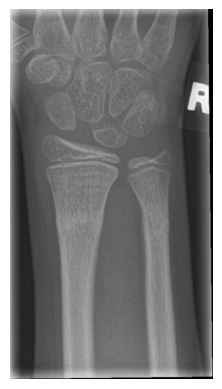

In [ ]:
plt.imshow(positive_images[0])
plt.axis('off')
plt.show()

In [ ]:
len(positive_images)

1130

In [ ]:
# Split positive images into train, validation, and test sets
X_positive_train, X_positive_temp, y_positive_train, y_positive_temp, positive_filenames_train, positive_filenames_temp = train_test_split(positive_images, dfp_copy['osteopenia'], positive_filenames, test_size=0.4, random_state=42, stratify=dfp_copy['osteopenia'])

X_positive_val, X_positive_test, y_positive_val, y_positive_test, positive_filenames_val, positive_filenames_test = train_test_split(X_positive_temp, y_positive_temp, positive_filenames_temp, test_size=0.5, random_state=42, stratify=y_positive_temp)

# Split negative images into train, validation, and test sets
X_negative_train, X_negative_temp, y_negative_train, y_negative_temp, negative_filenames_train, negative_filenames_temp = train_test_split(negative_images, dfn_copy['osteopenia'], negative_filenames, test_size=0.4, random_state=42, stratify=dfn_copy['osteopenia'])

X_negative_val, X_negative_test, y_negative_val, y_negative_test, negative_filenames_val, negative_filenames_test = train_test_split(X_negative_temp, y_negative_temp, negative_filenames_temp, test_size=0.5, random_state=42, stratify=y_negative_temp)


In [ ]:
len(X_positive_train)

678

In [ ]:
len(X_negative_test)

1185

In [ ]:
dfn_copy.to_csv('dfn_copy.csv')

In [ ]:
X_positive_train[0].shape

(846, 543, 3)

In [ ]:
#Augmentation parameters
augmentation_params = {
    'rotation_range': 20, # Rotate images by up to 20 degrees
    'width_shift_range': 0.1,  # Shift width by up to 10%
    'height_shift_range': 0.1,  # Shift height by up to 10%
    'horizontal_flip': True,  # Flip images horizontally
    'vertical_flip': False,  # Flip images vertically
    'brightness_range': [0.8, 1.2],  # Adjust brightness
    'zoom_range': 0.1,  # Zoom images by up to 10%
    'shear_range': 0.1  # Shear images by up to 10%
}

#ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=augmentation_params['rotation_range'],
    width_shift_range=augmentation_params['width_shift_range'],
    height_shift_range=augmentation_params['height_shift_range'],
    horizontal_flip=augmentation_params['horizontal_flip'],
    vertical_flip=augmentation_params['vertical_flip'],
    brightness_range=augmentation_params['brightness_range'],
    zoom_range=augmentation_params['zoom_range'],
    shear_range=augmentation_params['shear_range']
)

In [ ]:
# Augment positive images with labels
X_positive_train_augmented = []
y_positive_train_augmented = []
positive_train_filenames_augmented = []  # New list for augmented file names

for img, label, filename in tqdm(zip(X_positive_train, y_positive_train, positive_filenames_train)):
    img_batch = img.reshape((1,) + img.shape)
    augmented_imgs = datagen.flow(img_batch, batch_size=1)
    original_index = len(X_positive_train_augmented)  # Store the index of the original image

    # Append original image
    X_positive_train_augmented.append(img)
    y_positive_train_augmented.append(label)
    positive_train_filenames_augmented.append(filename)  # Original filename

    # Generate and append augmented images
    for i in range(5):  # Augment each image 5 times
        augmented_img = next(augmented_imgs)[0].astype(np.uint8)  # Convert to np.uint8
        X_positive_train_augmented.append(augmented_img)
        y_positive_train_augmented.append(label)
        augmented_filename = f"{filename[:-4]}_{i+1}.png"  # Appending _(i+1) to the original filename
        positive_train_filenames_augmented.append(augmented_filename)
#678 iterations

678it [06:43,  1.68it/s]


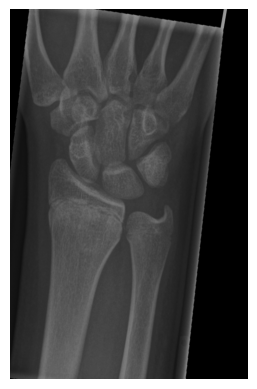

4068

In [ ]:
plt.imshow(X_positive_train_augmented[1])
plt.axis('off')
plt.show()
len(y_positive_train_augmented)

In [ ]:
positive_train_filenames_augmented[1]

In [ ]:
index = 1  #Max index = 677 (length of X_positive_train)
num_augmented_images = 5  # Number of augmented images generated for each original image

plt.figure(figsize=(15, 5))

# Plot the original image
plt.subplot(1, num_augmented_images + 1, 1)
plt.imshow(X_positive_train_augmented[index * (num_augmented_images + 1)])  # Adjusted indexing
plt.title('Original')
plt.axis('off')

# Plot the augmented images
for i in range(num_augmented_images):
    plt.subplot(1, num_augmented_images + 1, i + 2)
    plt.imshow(X_positive_train_augmented[index * (num_augmented_images + 1) + i + 1])  # Adjusted indexing
    plt.title(f'Augmented {i+1}')
    plt.axis('off')

plt.show()

In [ ]:
# Augment positive images with labels
X_positive_validation_augmented = []
y_positive_validation_augmented = []
positive_validation_filenames_augmented = []  # New list for augmented file names

for img, label, filename in tqdm(zip(X_positive_val, y_positive_val, positive_filenames_val)):
    img_batch = img.reshape((1,) + img.shape)
    augmented_imgs = datagen.flow(img_batch, batch_size=1)
    original_index = len(X_positive_validation_augmented)  # Store the index of the original image

    # Append original image
    X_positive_validation_augmented.append(img)
    y_positive_validation_augmented.append(label)
    positive_validation_filenames_augmented.append(filename)  # Original filename

    # Generate and append augmented images
    for i in range(5):  # Augment each image 5 times
        augmented_img = next(augmented_imgs)[0].astype(np.uint8)  # Convert to np.uint8
        X_positive_validation_augmented.append(augmented_img)
        y_positive_validation_augmented.append(label)
        augmented_filename = f"{filename[:-4]}_{i+1}.png"  # Appending _(i+1) to the original filename
        positive_validation_filenames_augmented.append(augmented_filename)
#226 iterations

226it [02:13,  1.69it/s]


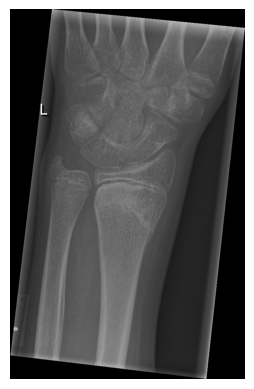

1356

In [ ]:
plt.imshow(X_positive_validation_augmented[6])
plt.axis('off')
plt.show()
len(y_positive_validation_augmented)

In [ ]:
positive_validation_filenames_augmented[6]

'4510_1224472627_05_WRI-L1_M014.png'

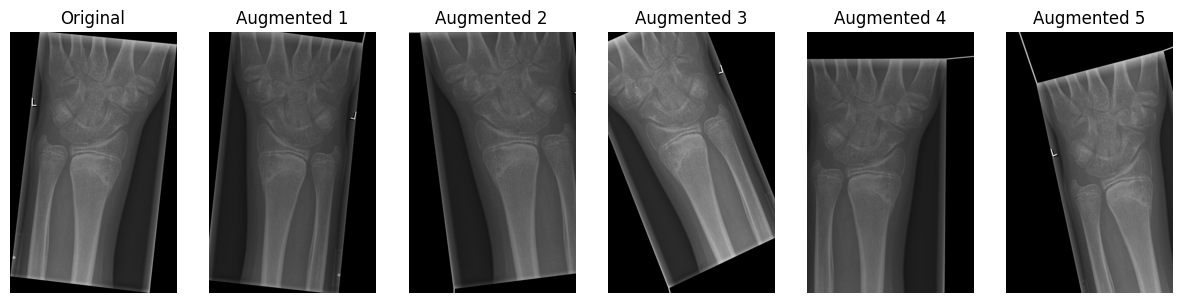

In [ ]:
index = 1  #Max index = 226 (length of X_positive_val)
num_augmented_images = 5  # Number of augmented images generated for each original image

plt.figure(figsize=(15, 5))

# Plot the original image
plt.subplot(1, num_augmented_images + 1, 1)
plt.imshow(X_positive_validation_augmented[index * (num_augmented_images + 1)])  # Adjusted indexing
plt.title('Original')
plt.axis('off')

# Plot the augmented images
for i in range(num_augmented_images):
    plt.subplot(1, num_augmented_images + 1, i + 2)
    plt.imshow(X_positive_validation_augmented[index * (num_augmented_images + 1) + i + 1])  # Adjusted indexing
    plt.title(f'Augmented {i+1}')
    plt.axis('off')

plt.show()

In [ ]:
# Augment positive images with labels
X_positive_testing_augmented = []
y_positive_testing_augmented = []
positive_testing_filenames_augmented = []  # New list for augmented file names

for img, label, filename in tqdm(zip(X_positive_test, y_positive_test, positive_filenames_test)):
    img_batch = img.reshape((1,) + img.shape)
    augmented_imgs = datagen.flow(img_batch, batch_size=1)
    original_index = len(X_positive_testing_augmented)  # Store the index of the original image

    # Append original image
    X_positive_testing_augmented.append(img)
    y_positive_testing_augmented.append(label)
    positive_testing_filenames_augmented.append(filename)  # Original filename

    # Generate and append augmented images
    for i in range(5):  # Augment each image 5 times
        augmented_img = next(augmented_imgs)[0].astype(np.uint8)  # Convert to np.uint8
        X_positive_testing_augmented.append(augmented_img)
        y_positive_testing_augmented.append(label)
        augmented_filename = f"{filename[:-4]}_{i+1}.png"  # Appending _(i+1) to the original filename
        positive_testing_filenames_augmented.append(augmented_filename)
#226 iterations

226it [02:11,  1.72it/s]


In [ ]:
plt.imshow(X_positive_testing_augmented[6])
plt.axis('off')
plt.show()
len(y_positive_testing_augmented)

In [ ]:
positive_testing_filenames_augmented[6]

In [ ]:
index = 1  #Max index = 226 (length of X_positive_test)
num_augmented_images = 5  # Number of augmented images generated for each original image

plt.figure(figsize=(15, 5))

# Plot the original image
plt.subplot(1, num_augmented_images + 1, 1)
plt.imshow(X_positive_testing_augmented[index * (num_augmented_images + 1)])  # Adjusted indexing
plt.title('Original')
plt.axis('off')

# Plot the augmented images
for i in range(num_augmented_images):
    plt.subplot(1, num_augmented_images + 1, i + 2)
    plt.imshow(X_positive_testing_augmented[index * (num_augmented_images + 1) + i + 1])  # Adjusted indexing
    plt.title(f'Augmented {i+1}')
    plt.axis('off')

plt.show()

In [ ]:
print('Original positive training images:', len(X_positive_train))
print('Augmented positive training images:', len(X_positive_train_augmented))
print('Original negative training images:', len(X_negative_train))
print()
print('Original positive validation images:', len(X_positive_val))
print('Augmented positive validation images:', len(X_positive_validation_augmented))
print('Original negative validation images:', len(X_negative_val))
print()
print('Original positive testing images:', len(X_positive_test))
print('Augmented positive testing images:', len(X_positive_testing_augmented))
print('Original negative testing images:', len(X_negative_test))

Original positive training images: 678
Augmented positive training images: 4068
Original negative training images: 3553

Original positive validation images: 226
Augmented positive validation images: 1356
Original negative validation images: 1185

Original positive testing images: 226
Augmented positive testing images: 1356
Original negative testing images: 1185


In [ ]:
target_size = (255, 255)
# Resize images with specified interpolation method
X_positive_train_augmented_resized = [cv2.resize(img, target_size) for img in X_positive_train_augmented]
X_negative_train_resized = [cv2.resize(img, target_size) for img in X_negative_train]

# Now, you can concatenate the resized arrays
X_train = np.concatenate((X_positive_train_augmented_resized, X_negative_train_resized))
y_train = np.concatenate((y_positive_train_augmented, y_negative_train))
train_filenames = np.concatenate((positive_train_filenames_augmented, negative_filenames_train))

In [ ]:
import pickle

In [ ]:
import numpy as np
import pickle

# Save X_train and y_train as .npy files
np.save('/kaggle/working/X_train.npy', X_train)
np.save('/kaggle/working/y_train.npy', y_train)

# Save train_filenames as a pickle file
with open('/kaggle/working/train_filenames.pkl', 'wb') as f:
    pickle.dump(train_filenames, f)

In [ ]:
X_train_ = np.load('/kaggle/input/train-data/X_train.npy')
y_train_ = np.load('/kaggle/input/augmented-data/y_train.npy')

# Load train_filenames
with open('/kaggle/input/augmented-data/train_filenames.pkl', 'rb') as f:
    train_filenames_ = pickle.load(f)

In [ ]:
X_train[1]

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [ ]:
X_train.shape

(7621, 255, 255, 3)

In [ ]:
X_train_.shape

(7621, 255, 255, 3)

In [ ]:
train_filenames_.shape

(7621,)

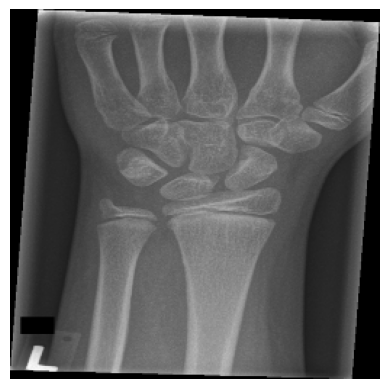

7621
7621


In [ ]:
plt.imshow(X_train[7620])
plt.axis('off')
plt.show()
print(len(X_train))
print(len(y_train))

In [ ]:
train_filenames[7620]

'4608_0925228667_01_WRI-L1_F011.png'

In [ ]:
# Resize images for validation set
target_size = (255, 255)
X_positive_val_augmented_resized = [cv2.resize(img, target_size) for img in X_positive_validation_augmented]
X_negative_val_resized = [cv2.resize(img, target_size) for img in X_negative_val]

# Concatenate the resized arrays for validation set
X_val = np.concatenate((X_positive_val_augmented_resized, X_negative_val_resized))
y_val = np.concatenate((y_positive_validation_augmented, y_negative_val))
val_filenames = np.concatenate((positive_validation_filenames_augmented, negative_filenames_val))

In [ ]:
np.save('/kaggle/working/X_val.npy', X_val)
np.save('/kaggle/working/y_val.npy', y_val)

# Save train_filenames as a pickle file
with open('/kaggle/working/val_filenames.pkl', 'wb') as f:
    pickle.dump(val_filenames, f)

In [ ]:
X_val_ = np.load('/kaggle/input/augmented-data/X_val.npy')
y_val_ = np.load('/kaggle/input/augmented-data/y_val.npy')

# Load train_filenames
with open('/kaggle/input/augmented-data/val_filenames.pkl', 'rb') as f:
    val_filenames_ = pickle.load(f)

In [ ]:
X_val_.shape

(2541, 255, 255, 3)

In [ ]:
X_val.shape

(2541, 255, 255, 3)

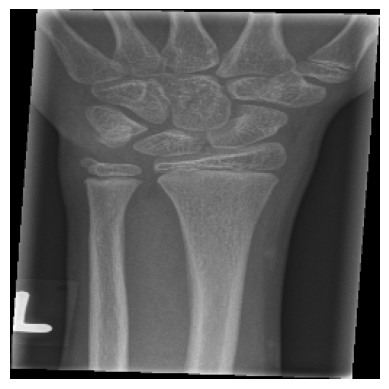

2541
2541


In [ ]:
plt.imshow(X_val[2540])
plt.axis('off')
plt.show()
print(len(X_val))
print(len(y_val))

In [ ]:
val_filenames[2540]

'3479_0091065735_01_WRI-L1_M012.png'

In [ ]:
# Resize images for testing set
target_size = (255, 255)
X_positive_test_augmented_resized = [cv2.resize(img, target_size) for img in X_positive_testing_augmented]
X_negative_test_resized = [cv2.resize(img, target_size) for img in X_negative_test]

# Concatenate the resized arrays for testing set
X_test = np.concatenate((X_positive_test_augmented_resized, X_negative_test_resized))
y_test = np.concatenate((y_positive_testing_augmented, y_negative_test))
test_filenames = np.concatenate((positive_testing_filenames_augmented, negative_filenames_test))

In [ ]:
np.save('/kaggle/working/X_test.npy', X_test)
np.save('/kaggle/working/y_test.npy', y_test)

# Save train_filenames as a pickle file
with open('/kaggle/working/test_filenames.pkl', 'wb') as f:
    pickle.dump(test_filenames, f)

In [ ]:
X_test_ = np.load('/kaggle/input/augmented-data/X_test.npy')
y_test_ = np.load('/kaggle/input/augmented-data/y_test.npy')

# Load train_filenames
with open('/kaggle/input/augmented-data/test_filenames.pkl', 'rb') as f:
    test_filenames_ = pickle.load(f)

In [ ]:
X_test_.shape

(2541, 255, 255, 3)

In [ ]:
X_test.shape

(2541, 255, 255, 3)

In [ ]:
from IPython.display import FileLink
FileLink(r'file.zip')

/kaggle/working/file.zip

In [ ]:
type(X_train[1])

numpy.ndarray

In [ ]:
train_filenames

array(['3390_0761007628_06_WRI-L1_F014.png',
       '3390_0761007628_06_WRI-L1_F014_1.png',
       '3390_0761007628_06_WRI-L1_F014_2.png', ...,
       '4801_0639679996_01_WRI-R1_F008.png',
       '2141_0468288554_01_WRI-R1_M016.png',
       '4608_0925228667_01_WRI-L1_F011.png'], dtype='<U36')

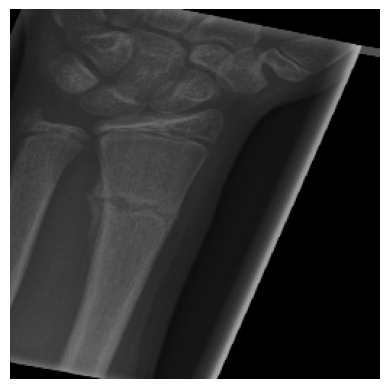

2541
2541


In [ ]:
plt.imshow(X_test[123])
plt.axis('off')
plt.show()
print(len(X_test))
print(len(y_test))

In [ ]:
test_filenames[123]

In [ ]:
print("Minimum pixel value:", np.min(X_train))
print("Maximum pixel value:", np.max(X_train))

Minimum pixel value: 0
Maximum pixel value: 255


In [ ]:
positive_images[134].shape

In [ ]:
# Assuming X_train is your array
data_type = X_train.dtype
print("Data type of X_train:", data_type)

Data type of X_train: uint8


In [ ]:
positive_images[657].shape

(1489, 1489, 3)

In [ ]:
import os
from PIL import Image
import pandas as pd
import numpy as np

In [ ]:
import os

In [ ]:
# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    # Make predictions on the test data
    y_pred = model.predict(X_test)
    # Convert predicted probabilities to binary predictions (0 or 1)
    y_pred_binary = (y_pred > 0.5).astype(int)
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred_binary)
    precision = precision_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    f1 = f1_score(y_test, y_pred_binary)
    roc_auc = roc_auc_score(y_test, y_pred)
    return accuracy, precision, recall, f1, roc_auc

In [ ]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
model.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 91.0MB/s]


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

# Custom Dataset Class
class NumpyDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]

        # Convert image from numpy array to PyTorch tensor (C, H, W)
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        if self.transform:
            image = self.transform(image)

        return image, label

# Data Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset1 = NumpyDataset(X_train_, y_train_, transform=transform)
val_dataset1 = NumpyDataset(X_val_, y_val_, transform=transform)
test_dataset1 = NumpyDataset(X_test_, y_test_, transform=transform)

train_loader = DataLoader(train_dataset1, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset1, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset1, batch_size=32, shuffle=False)

# Load Pre-trained GoogLeNet and Modify the Final Layer
model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
num_classes = 2  # Number of classes
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop with Validation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

num_epochs = 10
train_losses =[]
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in tqdm(range(num_epochs)):
    # Training Phase
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).long()  # Convert labels to LongTensor

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    epoch_train_loss = running_train_loss / len(train_loader)
    epoch_train_accuracy = 100.0 * correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # Validation Phase
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).long()  # Convert labels to LongTensor

            outputs = model(inputs)
            loss = criterion(outputs, labels)


            running_val_loss += loss.item()

            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    epoch_val_loss = running_val_loss / len(val_loader)
    epoch_val_accuracy = 100.0 * correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}]')
    print(f'Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.2f}%')
    print(f'Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.2f}%\n')




Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
 10%|█         | 1/10 [00:32<04:51, 32.35s/it]

Epoch [1/10]
Train Loss: 0.1725, Train Accuracy: 93.29%
Val Loss: 0.1389, Val Accuracy: 95.20%



 20%|██        | 2/10 [01:04<04:18, 32.37s/it]

Epoch [2/10]
Train Loss: 0.0905, Train Accuracy: 96.46%
Val Loss: 0.1699, Val Accuracy: 94.21%



 30%|███       | 3/10 [01:37<03:46, 32.39s/it]

Epoch [3/10]
Train Loss: 0.0878, Train Accuracy: 96.72%
Val Loss: 0.1342, Val Accuracy: 95.24%



 40%|████      | 4/10 [02:10<03:16, 32.78s/it]

Epoch [4/10]
Train Loss: 0.0659, Train Accuracy: 97.38%
Val Loss: 0.1442, Val Accuracy: 94.49%



 50%|█████     | 5/10 [02:42<02:43, 32.65s/it]

Epoch [5/10]
Train Loss: 0.0598, Train Accuracy: 97.87%
Val Loss: 0.1500, Val Accuracy: 94.84%



 60%|██████    | 6/10 [03:16<02:11, 32.81s/it]

Epoch [6/10]
Train Loss: 0.0561, Train Accuracy: 98.04%
Val Loss: 0.2041, Val Accuracy: 93.51%



 70%|███████   | 7/10 [03:48<01:37, 32.66s/it]

Epoch [7/10]
Train Loss: 0.0933, Train Accuracy: 96.48%
Val Loss: 0.1531, Val Accuracy: 94.88%



 80%|████████  | 8/10 [04:20<01:04, 32.49s/it]

Epoch [8/10]
Train Loss: 0.0448, Train Accuracy: 98.35%
Val Loss: 0.1997, Val Accuracy: 92.13%



 90%|█████████ | 9/10 [04:52<00:32, 32.41s/it]

Epoch [9/10]
Train Loss: 0.0430, Train Accuracy: 98.41%
Val Loss: 0.1491, Val Accuracy: 94.92%



100%|██████████| 10/10 [05:25<00:00, 32.53s/it]

Epoch [10/10]
Train Loss: 0.0212, Train Accuracy: 99.29%
Val Loss: 0.2321, Val Accuracy: 94.61%



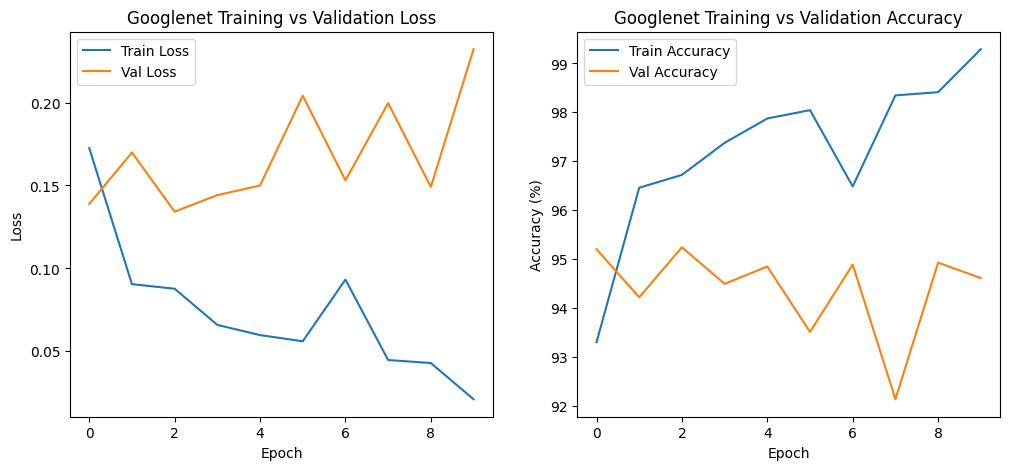

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Googlenet Training vs Validation Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Googlenet Training vs Validation Accuracy')
plt.legend()

plt.show()





In [ ]:
model.eval()

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:

correct_test = 0
total_test = 0

all_labels = []
all_predictions = []
all_probabilities = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Get predicted class and probabilities
        _, predicted = outputs.max(1)
        probabilities = nn.functional.softmax(outputs, dim=1)  # Convert logits to probabilities

        total_test += labels.size(0)
        correct_test += predicted.eq(labels).sum().item()

        # Store all predictions, probabilities, and true labels
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        all_probabilities.extend(probabilities[:, 1].cpu().numpy())  # We take the probability of class 1

# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)
all_probabilities = np.array(all_probabilities)


In [ ]:
print('Googlenet Metrics:')
test_accuracy = 100.0 * correct_test / total_test
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Calculate other evaluation metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

# ROC AUC for binary classification
roc_auc = roc_auc_score(all_labels, all_probabilities)


print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'ROC AUC Score: {roc_auc:.2f}')

Googlenet Metrics:
Test Accuracy: 95.67%
Accuracy: 0.96
Precision: 0.97
Recall: 0.94
F1 Score: 0.96
ROC AUC Score: 0.99


In [ ]:
torch.save(model.state_dict(), '/kaggle/working/googlenet_model.pth')

print("Model state_dict saved for googlenet model in 'googlenet_model.pth'")

Model state_dict saved for googlenet model in 'googlenet_model.pth'


In [ ]:
from torch.utils.data import Dataset, DataLoader
from transformers import ViTImageProcessor

class CustomDataset(Dataset):
    def __init__(self, images, labels, processor):
        self.images = images
        self.labels = labels
        self.processor = processor

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Process the image using ViTImageProcessor
        image = self.processor(images=image, return_tensors="pt")["pixel_values"].squeeze()

        return image, torch.tensor(label, dtype=torch.long)

# Initialize the processor
model_name = "google/vit-large-patch16-224"
processor = ViTImageProcessor.from_pretrained(model_name)

# Create datasets and dataloaders
train_dataset2 = CustomDataset(X_train_, y_train_, processor)
val_dataset2 = CustomDataset(X_val_, y_val_, processor)
test_dataset2 = CustomDataset(X_test_, y_test_, processor)

train_loader = DataLoader(train_dataset2, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset2, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset2, batch_size=32, shuffle=False)

In [ ]:
from transformers import ViTForImageClassification
import torch.nn as nn

num_classes = 2  # Binary classification (positive and negative)

# Define the label mappings
id2label = {0: 'negative', 1: 'positive'}
label2id = {v: k for k, v in id2label.items()}

# Load the model
model = ViTForImageClassification.from_pretrained(
    model_name, id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True
)

# Modify the classifier head for binary classification
model.classifier = nn.Linear(model.config.hidden_size, num_classes)

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-large-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([2, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.eval()

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-23): 24 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Lin

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-23): 24 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Lin

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).logits
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = running_val_loss / len(val_loader.dataset)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}%')
    print(f'Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.2f}%')


 10%|█         | 1/10 [08:49<1:19:21, 529.08s/it]

Epoch 1/10
Train Loss: 0.1430 | Train Accuracy: 94.31%
Val Loss: 0.0886 | Val Accuracy: 96.62%


 20%|██        | 2/10 [17:38<1:10:35, 529.45s/it]

Epoch 2/10
Train Loss: 0.0645 | Train Accuracy: 97.61%
Val Loss: 0.1069 | Val Accuracy: 96.06%


 30%|███       | 3/10 [26:28<1:01:47, 529.69s/it]

Epoch 3/10
Train Loss: 0.0376 | Train Accuracy: 98.57%
Val Loss: 0.1459 | Val Accuracy: 95.79%


 40%|████      | 4/10 [35:18<52:58, 529.81s/it]  

Epoch 4/10
Train Loss: 0.0403 | Train Accuracy: 98.56%
Val Loss: 0.2903 | Val Accuracy: 92.25%


 50%|█████     | 5/10 [44:08<44:09, 529.96s/it]

Epoch 5/10
Train Loss: 0.0286 | Train Accuracy: 98.85%
Val Loss: 0.1912 | Val Accuracy: 96.50%


 60%|██████    | 6/10 [52:59<35:20, 530.03s/it]

Epoch 6/10
Train Loss: 0.0134 | Train Accuracy: 99.55%
Val Loss: 0.2538 | Val Accuracy: 95.47%


 70%|███████   | 7/10 [1:01:49<26:30, 530.06s/it]

Epoch 7/10
Train Loss: 0.0136 | Train Accuracy: 99.53%
Val Loss: 0.1762 | Val Accuracy: 96.03%


 80%|████████  | 8/10 [1:10:39<17:40, 530.03s/it]

Epoch 8/10
Train Loss: 0.0061 | Train Accuracy: 99.71%
Val Loss: 0.1906 | Val Accuracy: 96.54%


 90%|█████████ | 9/10 [1:19:29<08:49, 529.99s/it]

Epoch 9/10
Train Loss: 0.0075 | Train Accuracy: 99.72%
Val Loss: 0.2131 | Val Accuracy: 96.30%


100%|██████████| 10/10 [1:28:18<00:00, 529.89s/it]

Epoch 10/10
Train Loss: 0.0117 | Train Accuracy: 99.65%
Val Loss: 0.2343 | Val Accuracy: 95.47%


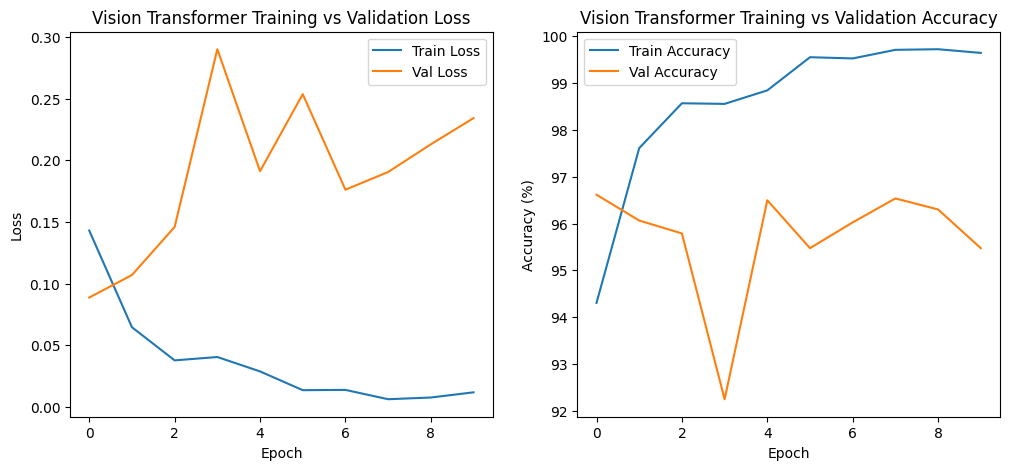

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Vision Transformer Training vs Validation Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Vision Transformer Training vs Validation Accuracy')
plt.legend()

plt.show()

In [ ]:
from torch import nn
from PIL import Image

In [ ]:
correct_test = 0
total_test = 0

all_labels = []
all_predictions = []
all_probabilities = []



def preprocess_images(images):
    # Convert images to PIL format if they are not already
    if isinstance(images[0], torch.Tensor):
        images = [Image.fromarray(img.numpy().astype(np.uint8).transpose(1, 2, 0)) for img in images]
    return processor(images=images, return_tensors="pt").pixel_values

with torch.no_grad():
    for inputs, labels in test_loader:
        # Preprocess inputs
        inputs = preprocess_images(inputs).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs).logits

        # Get predicted class and probabilities
        _, predicted = outputs.max(1)
        probabilities = nn.functional.softmax(outputs, dim=1)  # Convert logits to probabilities

        total_test += labels.size(0)
        correct_test += predicted.eq(labels).sum().item()

        # Store all predictions, probabilities, and true labels
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        all_probabilities.extend(probabilities[:, 1].cpu().numpy())  # We take the probability of class 1

# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)
all_probabilities = np.array(all_probabilities)

# Print test accuracy
test_accuracy = correct_test / total_test
print(f'Test Accuracy: {test_accuracy:.2f}')

Test Accuracy: 0.54


In [ ]:
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)
all_probabilities = np.array(all_probabilities)

# Calculate metrics
test_accuracy = 100.0 * correct_test / total_test
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)
roc_auc = roc_auc_score(all_labels, all_probabilities)

# Print metrics
print('ViT Metrics:')
print(f'Test Accuracy: {test_accuracy:.2f}%')
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'ROC AUC Score: {roc_auc:.2f}')

ViT Metrics:
Test Accuracy: 53.56%
Accuracy: 0.54
Precision: 0.53
Recall: 1.00
F1 Score: 0.70
ROC AUC Score: 0.49


In [ ]:
# Save the model state dictionary
torch.save(model.state_dict(), '/kaggle/working/vit_model_state_dict.pth')


In [ ]:
!zip -r file.zip /kaggle/working/

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/vit_model_state_dict.pth (deflated 7%)
  adding: kaggle/working/googlenet_model.pth (deflated 8%)


In [ ]:
from IPython.display import FileLink
FileLink(r'file.zip')

/kaggle/working/file.zip